# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [1]:
%matplotlib inline

import jittor
import jittor as jt
import jittor.nn as nn
from jittor import transform

import numpy as np
import matplotlib.pyplot as plt

# Uncomment to use gpu
# jt.flags.use_cuda = 1
    
print('Using Jittor version:', jittor.__version__)

[i 0310 12:13:36.270316 68 log.cc:351] Load log_sync: 1
[i 0310 12:13:36.295256 68 compiler.py:955] Jittor(1.3.6.10) src: /home/lzyhha/anaconda3/envs/jdet/lib/python3.8/site-packages/jittor
[i 0310 12:13:36.298770 68 compiler.py:956] g++ at /usr/bin/g++(9.4.0)
[i 0310 12:13:36.299407 68 compiler.py:957] cache_path: /home/lzyhha/.cache/jittor/jt1.3.6/g++9.4.0/py3.8.13/Linux-5.15.0-6xe4/12thGenIntelRCx51/default
[i 0310 12:13:36.303558 68 __init__.py:411] Found nvcc(11.7.64) at /usr/local/cuda-11.7/bin/nvcc.
[i 0310 12:13:36.332255 68 __init__.py:411] Found gdb(20.04.1) at /usr/bin/gdb.
[i 0310 12:13:36.336249 68 __init__.py:411] Found addr2line(2.34) at /usr/bin/addr2line.
[i 0310 12:13:36.417743 68 compiler.py:1010] cuda key:cu11.7.64_sm_86
[i 0310 12:13:36.529791 68 __init__.py:227] Total mem: 62.58GB, using 16 procs for compiling.
[i 0310 12:13:36.597343 68 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0310 12:13:36.675817 68 init.cc:62] Found cuda archs: [86,]
[i 0310 12:13:36.6

Using Jittor version: 1.3.6.10


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [2]:
batch_size = 32

train_loader = jt.dataset.MNIST(
    './data/', 
    train=True, 
    batch_size=batch_size, 
    shuffle=True, 
    transform=transform.Gray())

validation_loader = jt.dataset.MNIST(
    './data/', 
    train=False, 
    batch_size=1, 
    shuffle=False, 
    transform=transform.Gray())

9.46MB [00:02, 3.72MB/s]                            


The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.dtype)
    print('y_train:', y_train.size(), 'type:', y_train.dtype)
    break

X_train: [32,1,28,28,] type: float32
y_train: [32,] type: int32


Here are the first 10 training digits:

[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]
[32,1,28,28,]


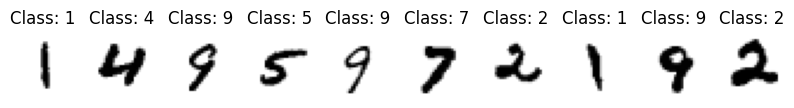

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    print(X_train.shape)
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
    def execute(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = nn.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = nn.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return nn.log_softmax(self.fc3(x), dim=1)

model = Net()
optimizer = jt.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
    fc1: Linear(784, 100, float32[100,], None)
    fc1_drop: Dropout(0.2, is_train=False)
    fc2: Linear(100, 80, float32[80,], None)
    fc2_drop: Dropout(0.2, is_train=False)
    fc3: Linear(80, 10, float32[10,], None)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [6]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate and update weights
        optimizer.step(loss)  #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [7]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.argmax(dim=1)[0] # get the index of the max log-probability
        correct += (pred == target).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.float32() / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [8]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/1875 (0%)]	Loss: 2.306888
Train Epoch: 1 [6400/1875 (11%)]	Loss: 2.061920
Train Epoch: 1 [12800/1875 (21%)]	Loss: 1.207647
Train Epoch: 1 [19200/1875 (32%)]	Loss: 0.706364
Train Epoch: 1 [25600/1875 (43%)]	Loss: 0.642222
Train Epoch: 1 [32000/1875 (53%)]	Loss: 0.373945
Train Epoch: 1 [38400/1875 (64%)]	Loss: 0.553418
Train Epoch: 1 [44800/1875 (75%)]	Loss: 0.359139
Train Epoch: 1 [51200/1875 (85%)]	Loss: 0.443128
Train Epoch: 1 [57600/1875 (96%)]	Loss: 0.644373

Validation set: Average loss: 0.3408, Accuracy: 9017/10000 (90%)

Train Epoch: 2 [0/1875 (0%)]	Loss: 0.451046
Train Epoch: 2 [6400/1875 (11%)]	Loss: 0.596838
Train Epoch: 2 [12800/1875 (21%)]	Loss: 0.476610
Train Epoch: 2 [19200/1875 (32%)]	Loss: 0.386908
Train Epoch: 2 [25600/1875 (43%)]	Loss: 0.353717
Train Epoch: 2 [32000/1875 (53%)]	Loss: 0.319995
Train Epoch: 2 [38400/1875 (64%)]	Loss: 0.380524
Train Epoch: 2 [44800/1875 (75%)]	Loss: 0.331995
Train Epoch: 2 [51200/1875 (85%)]	Loss: 0.155285
Train Epoch: 2

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

/home/lzyhha/anaconda3/envs/jdet/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'jittor_core.Var' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'jittor_core.Var', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lzyhha/anaconda3/envs/jdet/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


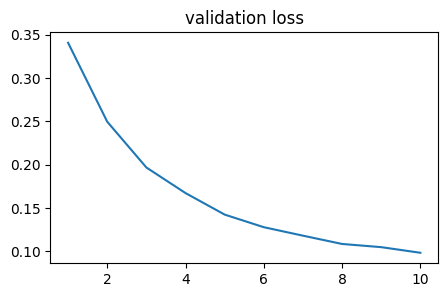

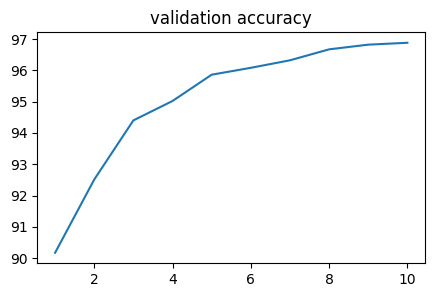

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs + 1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs + 1), accv)
plt.title('validation accuracy');

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.